In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
import itertools
from pprint import pprint
from tempeh.configurations import datasets
from fairlearn.postprocessing import ThresholdOptimizer
%matplotlib inline

In [2]:
path = 'compas-scores-two-years.csv'
#csv_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [3]:
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [4]:
#Assumption/ Implication: Those with high decile score will recidivate again
df['will_recidivate']  = (df['decile_score']>=5).astype(int)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,will_recidivate
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,1
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0


In [5]:
'''
Task: Calculating Accuracy where will recidivate attribtue matches whether the person 
actually commited the crime or not. 
Result: Too many false positives detected since 35 % of those classified as high risk are 
innocent
'''
correct_predictions = df['will_recidivate'] == df['two_year_recid']
prediction_accuracy = np.mean(correct_predictions)*100
prediction_accuracy

'\nTask: Calculating Accuracy where will recidivate attribtue matches whether the person \nactually commited the crime or not. \nResult: Too many false positives detected since 35 % of those classified as high risk are \ninnocent\n'

65.37288605489326

'Calculating Precision and Recall the dataset'

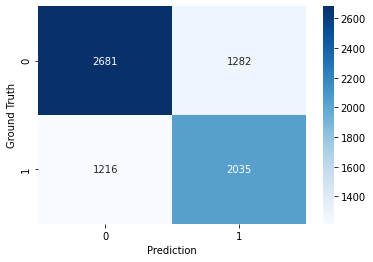

In [6]:
"""Calculating Precision and Recall the dataset"""
error_matrix = pd.crosstab(df['two_year_recid'], df['will_recidivate'], rownames=['Ground Truth'], colnames=['Prediction'])

labels = ['True Neg','False Pos','False Neg','True Pos']
confusion_matrix_plot = sns.heatmap(error_matrix, annot= True, fmt="", cmap= "Blues")

In [7]:
confusion_values = confusion_matrix(df['two_year_recid'], df['will_recidivate'])
[[true_negatives , false_positives],[false_negatives , true_positives]] = confusion_values
[[true_negatives , false_positives],[false_negatives , true_positives]]

[[2681, 1282], [1216, 2035]]

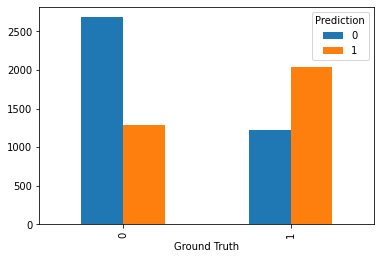

In [8]:
# t = df[df["two_year_recid"]==1]
# t.describe()
error_matrix.plot.bar()

In [9]:
row_normalized_error_matrix = pd.crosstab(df['two_year_recid'], df['will_recidivate'], rownames=['Ground Truth'], normalize="index", colnames=['Prediction'])

row_normalized_error_matrix

Prediction,0,1
Ground Truth,,
0,0.676508,0.323492
1,0.374039,0.625961


In [10]:
column_normalized_error_matrix = pd.crosstab(df['two_year_recid'], df['will_recidivate'], rownames=['Ground Truth'], normalize="columns", colnames=['Prediction'])
column_normalized_error_matrix

Prediction,0,1
Ground Truth,,
0,0.687965,0.386494
1,0.312035,0.613506


In [11]:
recall = true_positives/ (true_positives + false_negatives)
recall

0.6259612426945556

In [12]:
precision = true_positives/ (true_positives + false_positives)
precision

0.6135061802833887

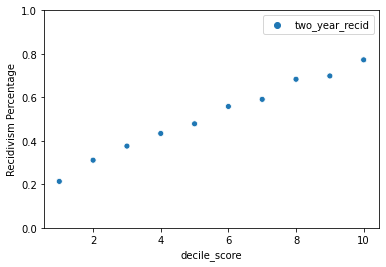

In [13]:
'''
seeing whether people with high recidivism score re-offended or not
'''
score_vs_gt = df.groupby('decile_score').agg({'two_year_recid': 'mean'})
sns.scatterplot(data = score_vs_gt);
plt.ylabel('Recidivism Percentage');
plt.ylim(0,1);


In [14]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

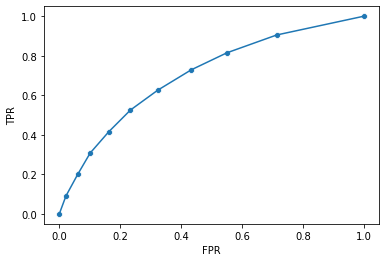

In [15]:
fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])  
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr, );
plt.ylabel("TPR");
plt.xlabel("FPR");

In [16]:
auc = roc_auc_score(df['two_year_recid'], df['decile_score'])
auc

0.7021662544019724

In [17]:
'''
Finding accuracy of two_year_recid gt against high recidivism score grouped by race.

Fairness Type: Overall Accuracy Equality
'''
race_df = df[df['race'].isin(['Caucasian','African-American'])]
(race_df['two_year_recid'] == race_df['will_recidivate']).astype(int).groupby(race_df['race']).mean()
#race_df

'\nFinding accuracy of two_year_recid gt against high recidivism score grouped by race.\n\nFairness Type: Overall Accuracy Equality\n'

race
African-American    0.638258
Caucasian           0.669927
dtype: float64

In [18]:
'''
checking probability for recidivism for person classifier as medium/high risk

Fairness Type: Predictive Parity
'''
race_df[race_df['will_recidivate']==1]['two_year_recid'].groupby(race_df['race']).mean()

'\nchecking probability for recidivism for person classifier as medium/high risk\n\nFairness Type: Predictive Parity\n'

race
African-American    0.629715
Caucasian           0.591335
Name: two_year_recid, dtype: float64

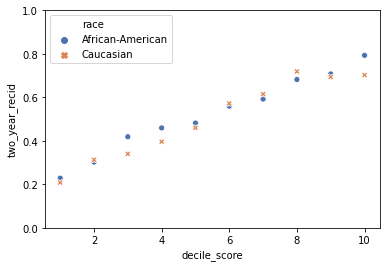

In [19]:
'''
checking if defendant with same score has 
similar probability for Caucasian and African-American groups both.

Fairness Type: Calibration
'''
d = pd.DataFrame(race_df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='decile_score', y='two_year_recid', palette= 'deep', hue='race', hue_norm=(0, 5), style= 'race');
im.set(ylim=(0,1));

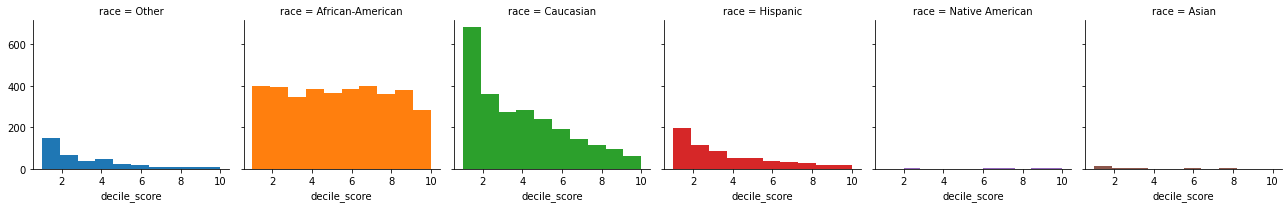

In [20]:
# frequency plot
g = sns.FacetGrid(df, col="race",hue = 'race', margin_titles=True);
g.map(plt.hist, "decile_score", bins=10);

In [21]:
'''
Checking average reoffending probability of both groups and their average decile score.
'''
race_df.groupby('race').agg({'two_year_recid': 'mean',  
                        'will_recidivate': 'mean', 
                        'decile_score': 'mean'}).transpose()

'\nChecking average reoffending probability of both groups and their average decile score.\n'

race,African-American,Caucasian
two_year_recid,0.514340,0.393643
will_recidivate,0.588203,0.348003
decile_score,5.368777,3.735126


In [22]:
caucasian_df = race_df[race_df['race'] == 'Caucasian']
af_am_df = race_df[race_df['race'] == 'African-American']


caucasian_confusion_values = confusion_matrix(caucasian_df['two_year_recid'], caucasian_df['will_recidivate'])
[[white_tn , white_fp],[white_fn , white_tp]] = caucasian_confusion_values

af_am_df_confusion_values = confusion_matrix(af_am_df['two_year_recid'], af_am_df['will_recidivate'])
[[black_tn , black_fp],[black_fn , black_tp]] = af_am_df_confusion_values
[[white_tn , white_fp],[white_fn , white_tp]]
[[black_tn , black_fp],[black_fn , black_tp]]


[[1139, 349], [461, 505]]

[[990, 805], [532, 1369]]

In [23]:
black_fpr = black_fp/ (black_fp + black_tn)
white_fpr = white_fp/ (white_fp + white_tn)

black_fnr = black_fn/ (black_fn + black_tp)
white_fnr = white_fn/ (white_fn + white_tp)


print(f'FPR for African-American Group: {black_fpr} | FPR for Caucasian Group: {white_fpr}')
print(f'FNR for African-American Group: {black_fnr} | FNR for Caucasian Group: {white_fnr}')

FPR for African-American Group: 0.44846796657381616 | FPR for Caucasian Group: 0.23454301075268819
FNR for African-American Group: 0.27985270910047344 | FNR for Caucasian Group: 0.4772256728778468


In [24]:
df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [25]:
df['vr_charge_degree'].unique()

array([nan, '(F3)', '(F2)', '(F1)', '(M1)', '(MO3)', '(M2)', '(F6)',
       '(F7)', '(F5)'], dtype=object)

# Training Random Forest on Original COMPAS Dataset

In [26]:
reoffend_df = pd.read_csv('archive/cox-violent-parsed.csv')

reqd_cols = ['age','c_charge_desc','c_charge_degree','c_days_from_compas',
  'is_recid', 
  'juv_fel_count', 
  'juv_misd_count', 
  'juv_other_count',
  'priors_count',
  'r_days_from_arrest',
  'race',
  'sex',
  'vr_charge_desc']

reoffend_df = reoffend_df[reqd_cols]
reoffend_df = reoffend_df[reoffend_df["is_recid"] != -1] #removing people with unknown reoffending activity
reoffend_df_race = reoffend_df[reoffend_df['race'].isin(['Caucasian','African-American'])]

reoffend_df_race.describe()

,age,c_days_from_compas,is_recid,juv_fel_count,juv_misd_count,juv_other_count,priors_count,r_days_from_arrest
count,15201.000000,15165.000000,15201.000000,15201.000000,15201.000000,15201.000000,15201.000000,5738.000000
mean,33.802973,58.414837,0.497007,0.085192,0.110519,0.139070,4.343333,19.897525
std,11.557081,322.564627,0.500007,0.470350,0.543038,0.548323,5.488404,74.566588
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,41.000000,2.000000,1.000000,0.000000,0.000000,0.000000,6.000000,1.000000
max,83.000000,9485.000000,1.000000,13.000000,13.000000,17.000000,43.000000,993.000000


In [27]:
reoffend_df_race.isnull().sum()

age                       0
c_charge_desc            50
c_charge_degree          36
c_days_from_compas       36
is_recid                  0
juv_fel_count             0
juv_misd_count            0
juv_other_count           0
priors_count              0
r_days_from_arrest     9463
race                      0
sex                       0
vr_charge_desc        14017
dtype: int64

In [28]:
reoffend_df_race = reoffend_df_race[reoffend_df_race['c_charge_desc'].notna()]
reoffend_df_race['r_days_from_arrest'] = reoffend_df_race['r_days_from_arrest'].fillna(reoffend_df_race['r_days_from_arrest'].mode()[0])
reoffend_df_race['vr_charge_desc'] = reoffend_df_race['vr_charge_desc'].fillna('na')
reoffend_df_race['c_charge_degree'] = reoffend_df_race['c_charge_degree'].apply(lambda x: 0 if x == 'F' else 1)

reoffend_df_race.isnull().sum()
reoffend_df_race.dtypes

age                   0
c_charge_desc         0
c_charge_degree       0
c_days_from_compas    0
is_recid              0
juv_fel_count         0
juv_misd_count        0
juv_other_count       0
priors_count          0
r_days_from_arrest    0
race                  0
sex                   0
vr_charge_desc        0
dtype: int64

age                     int64
c_charge_desc          object
c_charge_degree         int64
c_days_from_compas    float64
is_recid                int64
juv_fel_count           int64
juv_misd_count          int64
juv_other_count         int64
priors_count            int64
r_days_from_arrest    float64
race                   object
sex                    object
vr_charge_desc         object
dtype: object

In [29]:
data = reoffend_df_race.copy()
labels = data.pop('is_recid')
x_train, x_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.2, random_state = 42)


In [30]:
#encoding categorical features
categorical_features = x_train.columns[x_train.dtypes==object].tolist() 
col_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'), categorical_features),
                        remainder = "passthrough"
                        )
categorical_features

['c_charge_desc', 'race', 'sex', 'vr_charge_desc']

In [31]:
#le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#x_train = x_train.apply(le.fit_transform)

#x_train.head()

In [32]:
x_test.head()

,age,c_charge_desc,c_charge_degree,c_days_from_compas,juv_fel_count,juv_misd_count,juv_other_count,priors_count,r_days_from_arrest,race,sex,vr_charge_desc
683,20,Possession Burglary Tools,1,1.0,0,0,0,0,0.0,African-American,Male,na
10358,36,arrest case no charge,1,1.0,0,0,0,4,0.0,African-American,Male,na
9688,32,Possession Burglary Tools,1,1.0,0,0,0,0,0.0,Caucasian,Male,na
17862,36,Battery,1,1.0,0,0,0,1,0.0,African-American,Female,na
8366,34,Leaving Scene Accident w/Death,1,49.0,0,0,0,2,0.0,Caucasian,Male,na


In [33]:
rf_classifier = RandomForestClassifier(
                      n_estimators = 60,
                      n_jobs = -1,
                      #max_depth= 100,
                      random_state = 42,
                      max_features = 'auto')
model = make_pipeline(col_trans, rf_classifier)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['c_charge_desc', 'race',
                                                   'sex', 'vr_charge_desc'])],
                                   verbose=Fals...
                 RandomForestClassifier(bootstrap=True, 

0.8940943582975915

In [34]:
train_probs = model.predict_proba(x_train)[:,1] 
probs = model.predict_proba(x_test)[:, 1]
train_predictions = model.predict(x_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9988522339039958
Test ROC AUC  Score: 0.9534115951117963


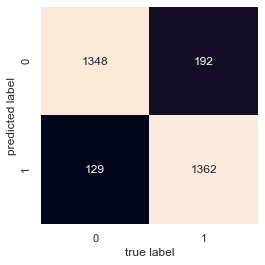

In [35]:
sns.set()
mat1 = confusion_matrix(y_test, model.predict(x_test))
#Construct confusion matrix
sns.heatmap(mat1,square=True, annot=True,fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [36]:
model.score(x_test, y_test)

0.8940943582975915

In [37]:
reoffend_df_race.copy().to_csv('preprocessed-cox-violent-parsed.csv')

In [38]:
len(x_train)

12120

In [39]:

propublica_dataset_df = pd.read_csv('archive/propublica_data_for_fairml.csv')
# divide the data into attributes and labels
X = propublica_dataset_df.drop(['Two_yr_Recidivism',], axis = 1)# 'Age_Below_TwentyFive', 'Age_Above_FourtyFive'
Y = propublica_dataset_df['Two_yr_Recidivism']

propublica_dataset_x_train, propublica_dataset_x_test, propublica_dataset_y_train, propublica_dataset_y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

propublica_categorical_features = propublica_dataset_x_train.columns[ propublica_dataset_x_train.dtypes==object].tolist() 
propublica_col_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'), propublica_categorical_features),
                        remainder = "passthrough"
                        )
model2 = rf_classifier
model2.fit(propublica_dataset_x_train, propublica_dataset_y_train)
propublica_y_pred = model2.predict(propublica_dataset_x_test)
accuracy_score(propublica_dataset_y_test, propublica_y_pred)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.6566801619433198

In [40]:
X.columns

Index(['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive',
       'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female', 'Misdemeanor'],
      dtype='object')

# Achieving Equalized Odds Fairness Using Fairlearn

In [41]:
compas_dataset = datasets["compas"]()
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)
(
    sensitive_features_train,
    sensitive_features_test,
) = compas_dataset.get_sensitive_features("race", format=pd.Series)
X_train.loc[0], y_train[0]

(age                        25.000000
 juv_fel_count               0.000000
 juv_misd_count             -2.340451
 juv_other_count             1.000000
 priors_count              -15.010999
 age_cat_25 - 45             1.000000
 age_cat_Greater than 45     0.000000
 age_cat_Less than 25        0.000000
 c_charge_degree_F           0.000000
 c_charge_degree_M           1.000000
 Name: 0, dtype: float64,
 1.0)

In [42]:
compas_dataset.get_sensitive_features("race", format=pd.Series)

(0       African-American
 1              Caucasian
 2              Caucasian
 3       African-American
 4              Caucasian
               ...       
 3531    African-American
 3532    African-American
 3533    African-American
 3534    African-American
 3535    African-American
 Name: race, Length: 3536, dtype: object,
 0       African-American
 1       African-American
 2              Caucasian
 3              Caucasian
 4              Caucasian
               ...       
 1737    African-American
 1738    African-American
 1739    African-American
 1740    African-American
 1741    African-American
 Name: race, Length: 1742, dtype: object)

In [43]:
X_train.columns

Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')

In [44]:
class RF(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.rf_model = model

    def fit(self, X, y):
        try:
            check_is_fitted(self.rf_model)
            self.rf_model_ = self.rf_model
        except NotFittedError:
            self.rf_model_ = clone(
                self.rf_model
            ).fit(X, y)
        return self

    def predict(self, X):
        scores = self.rf_model_.predict_proba(X)[:, 1]
        return scores

In [45]:
rf2 = RandomForestClassifier(
                      n_estimators = 60,
                      n_jobs = -1,
                      #max_depth= 100,
                      random_state = 42,
                      max_features = 'auto')
rf2.fit(X_train, y_train)
estimator_wrapper = RF(rf2).fit(X_train, y_train)

postprocessed_predictor_EO = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="equalized_odds", prefit=True
)

postprocessed_predictor_EO.fit(
    X_train, y_train, sensitive_features=sensitive_features_train
)

fairness_aware_predictions_EO_train = postprocessed_predictor_EO.predict(
    X_train, sensitive_features=sensitive_features_train
)
fairness_aware_predictions_EO_test = postprocessed_predictor_EO.predict(
    X_test, sensitive_features=sensitive_features_test
)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ThresholdOptimizer(constraints='equalized_odds', estimator=RF(model=None),
                   flip=False, grid_size=1000, objective='accuracy_score',
                   predict_method='deprecated', prefit=True)

In [46]:
def show_proportions(
    X, sensitive_features, y_pred, y=None, description=None, plot_row_index=1
):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    plt.ylabel("P[recidivism predicted | conditions]")

    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    for group in groups:
        print(f'group: {group} len: {len(group)}')
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0, 1, n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group] / len(indices[group])
        print(
            "P[recidivism predicted | {}]                {}= {}".format(
                group, " " * (max_group_length - len(group)), recidivism_pct[group]
            )
        )

        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)

        if y is not None:
            positive_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == 1)
            ]
            negative_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == 0)
            ]
            prob_1 = sum(y_pred[positive_indices[group]]) / len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]]) / len(negative_indices[group])
            print(
                "P[recidivism predicted | {}, recidivism]    {}= {}".format(
                    group, " " * (max_group_length - len(group)), prob_1
                )
            )
            print(
                "P[recidivism predicted | {}, no recidivism] {}= {}".format(
                    group, " " * (max_group_length - len(group)), prob_0
                )
            )

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(
                ["{} recidivism".format(group), "{} no recidivism".format(group)]
            )

    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(
        range(1, len(x_tick_labels) + 1),
        x_tick_labels,
        rotation=45,
        horizontalalignment="right",
    )


Fairness Unaware Random Forest
group: African-American len: 16
group: Caucasian len: 9
P[recidivism predicted | African-American]                = 0.5175097276264592
P[recidivism predicted | African-American, recidivism]    = 0.6595365418894831
P[recidivism predicted | African-American, no recidivism] = 0.3468950749464668
P[recidivism predicted | Caucasian]                       = 0.33053221288515405
P[recidivism predicted | Caucasian, recidivism]           = 0.5239852398523985
P[recidivism predicted | Caucasian, no recidivism]        = 0.21218961625282168

Equalized Odds Postprocessing Using Fairlearn
group: African-American len: 16
group: Caucasian len: 9
P[recidivism predicted | African-American]                = 0.5126459143968871
P[recidivism predicted | African-American, recidivism]    = 0.6541889483065954
P[recidivism predicted | African-American, no recidivism] = 0.3426124197002141
P[recidivism predicted | Caucasian]                       = 0.3851540616246499
P[recidivism pred

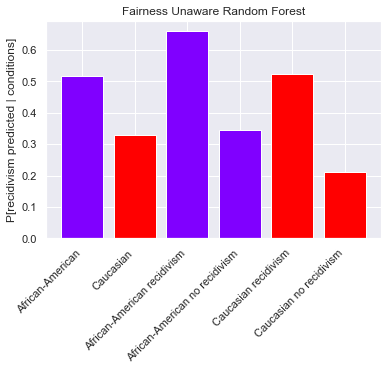

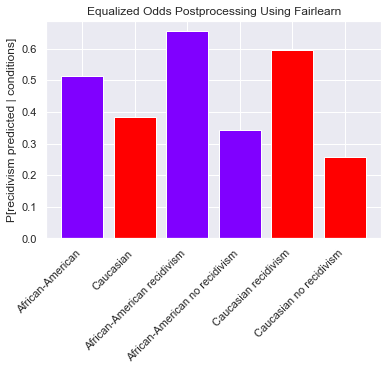

In [47]:
show_proportions(
    X_test,
    sensitive_features_test,
    rf2.predict(X_test),
    y_test,
    description="Fairness Unaware Random Forest",
    plot_row_index=1,
)
show_proportions(
    X_test,
    sensitive_features_test,
    fairness_aware_predictions_EO_test,
    y_test,
    description="Equalized Odds Postprocessing Using Fairlearn",
    plot_row_index=2,
)
plt.show()

In [48]:
unaware_y_pred = rf2.predict(X_test)
accuracy_score(y_test, unaware_y_pred)

0.669345579793341

In [49]:
accuracy_score(y_test, fairness_aware_predictions_EO_test)

0.6681974741676234

In [50]:
class LR(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.rf_model = model

    def fit(self, X, y):
        try:
            check_is_fitted(self.rf_model)
            self.rf_model_ = self.rf_model
        except NotFittedError:
            self.rf_model_ = clone(
                self.rf_model
            ).fit(X, y)
        return self

    def predict(self, X):
        scores = self.rf_model_.predict_proba(X)[:, 1]
        return scores

In [51]:
from sklearn.linear_model import LogisticRegression

compas_dataset = datasets["compas"]()
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)
(
    sensitive_features_train,
    sensitive_features_test,
) = compas_dataset.get_sensitive_features("race", format=pd.Series)
fairness_unaware_lr = LogisticRegression(solver='liblinear', fit_intercept=True)
fairness_unaware_lr.fit(X_train, y_train)

y_preds_lr = fairness_unaware_lr.predict(X_test)
#accuracy_score(y_test, y_preds_lr)


estimator_wrapper_lr = LR(fairness_unaware_lr).fit(X_train, y_train)

postprocessed_predictor_EO_lr = ThresholdOptimizer(
    estimator=estimator_wrapper_lr, constraints="equalized_odds", prefit=True
    #estimator=estimator_wrapper_rf, constraints="false_positive_rate_parity", prefit=True
)

postprocessed_predictor_EO_lr.fit(
    X_train, y_train, sensitive_features=sensitive_features_train
)

fairness_aware_predictions_EO_train_lr = postprocessed_predictor_EO_lr.predict(
    X_train, sensitive_features=sensitive_features_train
)
fairness_aware_predictions_EO_test_lr = postprocessed_predictor_EO_lr.predict(
    X_test, sensitive_features=sensitive_features_test
)
unaware_y_pred_lr = fairness_unaware_lr.predict(X_test)
accuracy_score(y_test, unaware_y_pred_lr)
accuracy_score(y_test, fairness_aware_predictions_EO_test_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ThresholdOptimizer(constraints='equalized_odds', estimator=LR(model=None),
                   flip=False, grid_size=1000, objective='accuracy_score',
                   predict_method='deprecated', prefit=True)

0.6590126291618829

0.618828932261768

# Checking Fairness Constraints Broken After Equalized Odds Is Achieved

In [52]:
X_train['race'] = sensitive_features_train 
X_test['race'] = sensitive_features_test

X_train['equalized_odds_preds'] = fairness_aware_predictions_EO_train
X_test['equalized_odds_preds'] = fairness_aware_predictions_EO_test
X_test['equalized_odds_preds_lr'] = fairness_aware_predictions_EO_test_lr

#X_train['reoffended_preds'] = rf2.predict(X_train)
X_test['reoffended_preds'] = unaware_y_pred
X_test['reoffended_preds_lr'] = unaware_y_pred_lr

X_train['reoffended_gt'] = y_train
X_test['reoffended_gt'] = y_test

equalized_odds_data = pd.concat([X_train, X_test], ignore_index=True)
equalized_odds_data['equalized_odds_preds'] = equalized_odds_data['equalized_odds_preds'].astype('float64')
equalized_odds_data.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,race,equalized_odds_preds,reoffended_gt,equalized_odds_preds_lr,reoffended_preds,reoffended_preds_lr
0,25.000000,0.0,-2.340451,1.0,-15.010999,1.0,0.0,0.0,0.0,1.0,African-American,1.0,1.0,NaN,NaN,NaN
1,26.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,Caucasian,0.0,0.0,NaN,NaN,NaN
2,21.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,Caucasian,1.0,1.0,NaN,NaN,NaN
3,29.129788,0.0,0.000000,0.0,6.000000,1.0,0.0,0.0,0.0,1.0,African-American,1.0,1.0,NaN,NaN,NaN
4,42.487893,0.0,0.000000,0.0,7.513697,1.0,0.0,0.0,1.0,0.0,Caucasian,0.0,0.0,NaN,NaN,NaN


In [53]:
conf_matr = pd.crosstab(equalized_odds_data['reoffended_gt'], equalized_odds_data['equalized_odds_preds'], rownames=['Ground Truth'], normalize="columns", colnames=['Prediction'])
conf_matr

Prediction,0.0,1.0
Ground Truth,,
0.0,0.813635,0.178042
1.0,0.186365,0.821958


In [54]:
'''
Finding accuracy of two_year_recid gt against high recidivism score grouped by race. (Before fainress)

Fairness Type: Overall Accuracy Equality
'''
race_df = X_test[X_test['race'].isin(['Caucasian','African-American'])]
(race_df['reoffended_gt'] == race_df['reoffended_preds']).astype(int).groupby(race_df['race']).mean()


'''
Finding accuracy of two_year_recid gt against high recidivism score grouped by race.

Fairness Type: Overall Accuracy Equality
'''
# race_df = equalized_odds_data[equalized_odds_data['race'].isin(['Caucasian','African-American'])]
# (race_df['reoffended_gt'] == race_df['equalized_odds_preds']).astype(int).groupby(race_df['race']).mean()

(race_df['reoffended_gt'] == race_df['equalized_odds_preds']).astype(int).groupby(race_df['race']).mean()



'\nFinding accuracy of two_year_recid gt against high recidivism score grouped by race. (Before fainress)\n\nFairness Type: Overall Accuracy Equality\n'

race
African-American    0.656615
Caucasian           0.687675
dtype: float64

'\nFinding accuracy of two_year_recid gt against high recidivism score grouped by race.\n\nFairness Type: Overall Accuracy Equality\n'

race
African-American    0.655642
Caucasian           0.686275
dtype: float64

In [55]:
'''
checking probability for recidivism for person classifier as medium/high risk. Before Fairness

Fairness Type: Predictive Parity (Constraint Not Satisfied)
'''
race_df[race_df['reoffended_preds']==1]['reoffended_gt'].groupby(race_df['race']).mean()
'''
checking probability for recidivism for person classifier as medium/high risk

Fairness Type: Predictive Parity (Constraint Not Satisfied)
'''
race_df[race_df['equalized_odds_preds']==1]['reoffended_gt'].groupby(race_df['race']).mean()

'\nchecking probability for recidivism for person classifier as medium/high risk. Before Fairness\n\nFairness Type: Predictive Parity (Constraint Not Satisfied)\n'

race
African-American    0.695489
Caucasian           0.601695
Name: reoffended_gt, dtype: float64

'\nchecking probability for recidivism for person classifier as medium/high risk\n\nFairness Type: Predictive Parity (Constraint Not Satisfied)\n'

race
African-American    0.696395
Caucasian           0.585455
Name: reoffended_gt, dtype: float64

In [56]:
groups = np.unique(sensitive_features_test.values)
groups

array(['African-American', 'Caucasian'], dtype=object)

In [57]:
race_df.columns

Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M',
       'race', 'equalized_odds_preds', 'equalized_odds_preds_lr',
       'reoffended_preds', 'reoffended_preds_lr', 'reoffended_gt'],
      dtype='object')

In [58]:
accuracy_score(race_df['reoffended_gt'], race_df['reoffended_preds'])

0.669345579793341

In [59]:
accuracy_score(race_df['reoffended_gt'], race_df['equalized_odds_preds'])

0.6681974741676234

In [60]:
'''
Logistic Regression: Finding accuracy of two_year_recid gt against high recidivism score grouped by race. (Before fainress)

Fairness Type: Overall Accuracy Equality
'''
(race_df['reoffended_gt'] == race_df['reoffended_preds_lr']).astype(int).groupby(race_df['race']).mean()
'''
Finding accuracy of two_year_recid gt against high recidivism score grouped by race.

Fairness Type: Overall Accuracy Equality
'''
# race_df = equalized_odds_data[equalized_odds_data['race'].isin(['Caucasian','African-American'])]
# (race_df['reoffended_gt'] == race_df['equalized_odds_preds']).astype(int).groupby(race_df['race']).mean()

(race_df['reoffended_gt'] == race_df['equalized_odds_preds_lr']).astype(int).groupby(race_df['race']).mean()


'\nLogistic Regression: Finding accuracy of two_year_recid gt against high recidivism score grouped by race. (Before fainress)\n\nFairness Type: Overall Accuracy Equality\n'

race
African-American    0.660506
Caucasian           0.656863
dtype: float64

'\nFinding accuracy of two_year_recid gt against high recidivism score grouped by race.\n\nFairness Type: Overall Accuracy Equality\n'

race
African-American    0.613813
Caucasian           0.626050
dtype: float64

In [61]:
'''
Logisitc Regression: checking probability for recidivism for person classifier as medium/high risk. Before Fairness

Fairness Type: Predictive Parity (Constraint Not Satisfied)
'''
race_df[race_df['reoffended_preds_lr']==1]['reoffended_gt'].groupby(race_df['race']).mean()
'''
checking probability for recidivism for person classifier as medium/high risk

Fairness Type: Predictive Parity (Constraint Not Satisfied)
'''
race_df[race_df['equalized_odds_preds_lr']==1]['reoffended_gt'].groupby(race_df['race']).mean()

'\nLogisitc Regression: checking probability for recidivism for person classifier as medium/high risk. Before Fairness\n\nFairness Type: Predictive Parity (Constraint Not Satisfied)\n'

race
African-American    0.700000
Caucasian           0.563725
Name: reoffended_gt, dtype: float64

'\nchecking probability for recidivism for person classifier as medium/high risk\n\nFairness Type: Predictive Parity (Constraint Not Satisfied)\n'

race
African-American    0.672996
Caucasian           0.505988
Name: reoffended_gt, dtype: float64

In [62]:
def calc_confusion_metrics(df, tag='rf', fair=False):
    cauc_df = df[df['race'] == 'Caucasian']
    afroam_df = df[df['race'] == 'African-American']

    if tag == 'rf':
        if not fair:
            pred_col = 'reoffended_preds' 
        else:
             pred_col = 'equalized_odds_preds'
    elif tag == 'lr':
        if not fair:
            pred_col = 'reoffended_preds_lr'
        else:
            pred_col = 'equalized_odds_preds_lr'
        
    cauc_confusion_values = confusion_matrix(cauc_df['reoffended_gt'], cauc_df[pred_col])
    [[male_tn , male_fp],[male_fn , male_tp]] = cauc_confusion_values

    female_confusion_values = confusion_matrix(afroam_df['reoffended_gt'], afroam_df[pred_col])
    [[female_tn , female_fp],[female_fn , female_tp]] = female_confusion_values
    return [[male_tn , male_fp],[male_fn , male_tp]],[[female_tn , female_fp],[female_fn , female_tp]]

lr_white_metrics, lr_black_metrics = calc_confusion_metrics(race_df, tag='lr')
rf_white_metrics, rf_black_metrics = calc_confusion_metrics(race_df)

print(f'LR CM for Caucasian: {lr_white_metrics}\tAfrican-American: {lr_black_metrics}')
print(f'RF CM for M: {rf_white_metrics}\tF: {rf_black_metrics}')

def fpr_fnr(male_metrics,female_metrics, tag= 'LR'):
    [[male_tn , male_fp],[male_fn , male_tp]] = male_metrics
    [[female_tn , female_fp],[female_fn , female_tp]] = female_metrics
    
    female_fpr = female_fp/ (female_fp + female_tn)
    male_fpr = male_fp/ (male_fp + male_tn)

    female_fnr = female_fn/ (female_fn + female_tp)
    male_fnr = male_fn/ (male_fn + male_tp)
    print(tag)
    print(f'FPR for African American Group: {female_fpr} | FPR for Caucasian group: {male_fpr}')
    print(f'FNR for African American Group: {female_fnr} | FNR for Caucasian group: {male_fnr}\n\n')
    
fpr_fnr(lr_white_metrics, lr_black_metrics, tag= 'LR')
fpr_fnr(rf_white_metrics, rf_black_metrics, tag= 'RF')

LR CM for Caucasian: [[354, 89], [156, 115]]	African-American: [[308, 159], [190, 371]]
RF CM for M: [[349, 94], [129, 142]]	F: [[305, 162], [191, 370]]
LR
FPR for African American Group: 0.3404710920770878 | FPR for Caucasian group: 0.20090293453724606
FNR for African American Group: 0.33868092691622104 | FNR for Caucasian group: 0.5756457564575646


RF
FPR for African American Group: 0.3468950749464668 | FPR for Caucasian group: 0.21218961625282168
FNR for African American Group: 0.3404634581105169 | FNR for Caucasian group: 0.47601476014760147




In [64]:
lr_white_metrics, lr_black_metrics = calc_confusion_metrics(race_df, tag='lr', fair= True)
rf_white_metrics, rf_black_metrics = calc_confusion_metrics(race_df, fair= True)
fpr_fnr(lr_white_metrics, lr_black_metrics, tag= 'LR')
fpr_fnr(rf_white_metrics, rf_black_metrics, tag= 'RF')

LR
FPR for African American Group: 0.33190578158458245 | FPR for Caucasian group: 0.3724604966139955
FNR for African American Group: 0.43137254901960786 | FNR for Caucasian group: 0.3763837638376384


RF
FPR for African American Group: 0.3426124197002141 | FPR for Caucasian group: 0.25733634311512416
FNR for African American Group: 0.34581105169340465 | FNR for Caucasian group: 0.4059040590405904


